In [63]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, classification_report, plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sb
from dython import nominal
from sklearn.svm import SVC

In [2]:
trainData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')

In [3]:
x_train = trainData.drop(columns=['status'])
y_train = trainData['status']
x_test = testData.drop(columns=['status'])
y_test = testData['status']

### Machine learning model with default parameter

In [4]:
logistic = LogisticRegression()
forest = RandomForestClassifier()
adaboost = AdaBoostClassifier()
knn = KNeighborsClassifier()
svc = SVC()

In [5]:
logistic.fit(x_train,y_train)
forest.fit(x_train,y_train)
adaboost.fit(x_train,y_train)
knn.fit(x_train,y_train)
svc.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Accuracy score before hyperparameter tuning

In [6]:
def model_score(model):
    return round(model.score(x_test,y_test)*100, 2)

,Logistic,Random Forest,Adaboost,KNN,SVC
Before tuning,72.73,72.73,81.82,78.79,69.7


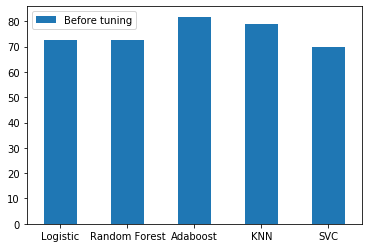

In [7]:
log_score = model_score(logistic)
forest_score = model_score(forest)
ada_score = model_score(adaboost)
knn_score = model_score(knn)
svc_score = model_score(svc)

scoreNotune = pd.DataFrame({'Before tuning':[log_score, forest_score, ada_score,knn_score,svc_score]},index=['Logistic','Random Forest','Adaboost','KNN','SVC']).T
scoreNotune.T.plot(kind='bar',rot=0)
scoreNotune

In [8]:
def tuning(model, parameter, n_cv):
    grid = RandomizedSearchCV(model, parameter, cv = n_cv)
    grid.fit(x_train,y_train)
    best_param = grid.best_params_
    return best_param

In [9]:
log_param = {
    'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
    'penalty':['none','l1','l2','elasticnet'],
    'C':[100,10,1.0,0.1,0.01]
}

log_best = tuning(logistic,log_param,10)

In [11]:
forest_param = {
    'n_estimators': [10,100,1000],
    'min_samples_split': [i for i in range(2,21,2)],
    'min_samples_leaf': [i for i in range(1,12)],
    'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt','log2'],
    'criterion':['gini','entropy']
}

forest_best = tuning(forest,forest_param,10)

In [13]:
ada_param = {
    'n_estimators':[100,200,300],
    'algorithm':['SAMME', 'SAMME.R']
}

ada_best = tuning(adaboost, ada_param, 10)

In [15]:
knn_param = {
    'leaf_size' : list(range(1,50)),
    'n_neighbors' : list(range(1,30)),
    'p':[1,2],
    'weights':['uniform','distance'],
    'algorithm':['auto','ball_tree','kd_tree','brute']
}

knn_best = tuning(knn, knn_param, 10)

In [16]:
svc_param = {
    'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']
}

svc_best = tuning(svc,svc_param,10)

In [17]:
print(log_best)
print(forest_best)
print(ada_best)
print(knn_best)
print(svc_best)

{'solver': 'liblinear', 'penalty': 'l2', 'C': 10}
{'n_estimators': 100, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'gini'}
{'n_estimators': 300, 'algorithm': 'SAMME.R'}
{'weights': 'distance', 'p': 2, 'n_neighbors': 11, 'leaf_size': 31, 'algorithm': 'brute'}
{'kernel': 'poly', 'gamma': 0.01, 'C': 100}


In [18]:
logOptimum = LogisticRegression(solver=log_best['solver'],penalty=log_best['penalty'],C=log_best['C'])
forestOptimum = RandomForestClassifier(n_estimators=forest_best['n_estimators'], min_samples_split=forest_best['min_samples_split'], min_samples_leaf=forest_best['min_samples_leaf'], max_features=forest_best['max_features'], max_depth=forest_best['max_depth'], criterion=forest_best['criterion'])
adaOptimum = AdaBoostClassifier(n_estimators=ada_best['n_estimators'],algorithm=ada_best['algorithm'])
knnOptimum = KNeighborsClassifier(p=knn_best['p'], n_neighbors=knn_best['n_neighbors'], leaf_size=knn_best['leaf_size'],weights=knn_best['weights'],algorithm=knn_best['algorithm'])
svcOptimum = SVC(C=svc_best['C'],gamma=svc_best['gamma'],kernel=svc_best['kernel'])

In [19]:
logOptimum.fit(x_train,y_train)
forestOptimum.fit(x_train,y_train)
adaOptimum.fit(x_train,y_train)
knnOptimum.fit(x_train,y_train)
svcOptimum.fit(x_train,y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [26]:
log_score_tune = model_score(logOptimum)
forest_score_tune = model_score(forestOptimum)
ada_score_tune = model_score(adaOptimum)
knn_score_tune = model_score(knnOptimum)
svc_score_tune = model_score(svcOptimum)

scoreTune = pd.DataFrame({'After tuning':[log_score_tune,forest_score_tune,ada_score_tune,knn_score_tune,svc_score_tune]}, index=['Logistic','Random Forest','Adaboost','KNN','SVC']).T

,Before tuning,After tuning
Logistic,72.73,75.76
Random Forest,72.73,75.76
Adaboost,81.82,81.82
KNN,78.79,78.79
SVC,69.70,75.76


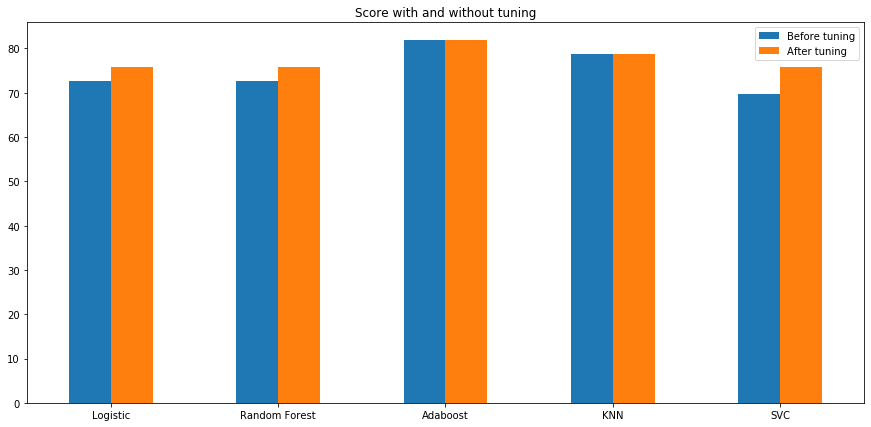

In [43]:
scores = pd.concat([scoreNotune,scoreTune]).T
scores.plot(kind='bar',rot=0,figsize=(15,7),title='Score with and without tuning')
scores

In [98]:
optimum = {
    'Logistic':logOptimum,'Random Forest':forestOptimum,'Adaboost':adaOptimum,'KNN':knnOptimum,'SVC':svcOptimum
}

def classification(model):
    for key in list(optimum.keys()):
        print(f'Classfication report for {key}:\n {classification_report(y_test,optimum[key].predict(x_test))}') 

classification(optimum)

Classfication report for Logistic:
               precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.79      0.86      0.83        22

    accuracy                           0.76        33
   macro avg       0.73      0.70      0.71        33
weighted avg       0.75      0.76      0.75        33

Classfication report for Random Forest:
               precision    recall  f1-score   support

           0       0.67      0.55      0.60        11
           1       0.79      0.86      0.83        22

    accuracy                           0.76        33
   macro avg       0.73      0.70      0.71        33
weighted avg       0.75      0.76      0.75        33

Classfication report for Adaboost:
               precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.83      0.91      0.87        22

    accuracy                           0.82        33
   macro avg   

Confusion matrix for Logistic


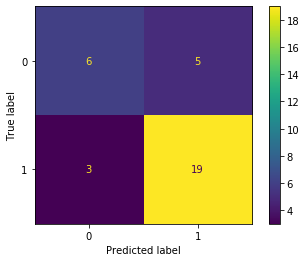

Confusion matrix for Random Forest


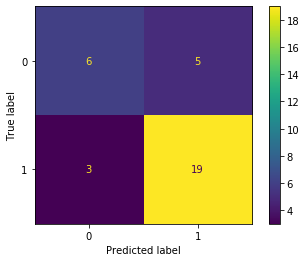

Confusion matrix for Adaboost


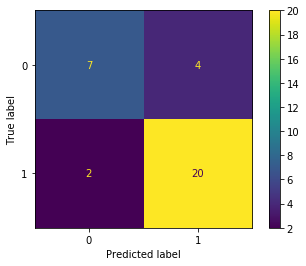

Confusion matrix for KNN


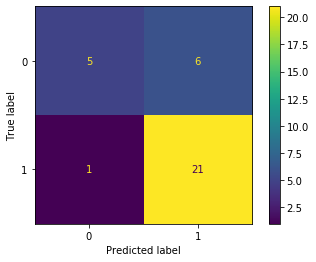

Confusion matrix for SVC


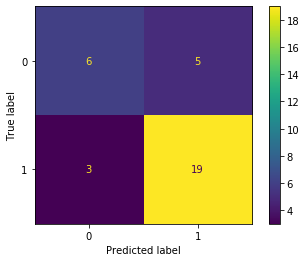

In [99]:
keys = list(optimum.keys())

def confuse(model):
    for key in keys:
        print(f'Confusion matrix for {key}')
        plot_confusion_matrix(optimum[key],x_test,y_test,values_format='0.0f',)
        plt.show()

confuse(keys)